In [1]:
import torch
import os
from models.RecSysFlat import RecSysGarbageNetV2
import data_mgmt.RecSysData as rsd
from data_mgmt.RecSysDataTest import TestRecSysData
import seaborn as sns
from torch.optim.swa_utils import AveragedModel

# default imports because meh
import numpy as np
import pandas as pd

In [11]:
# # # # # # # # # # # # # # # #
# INPUTS TO POST PROCESSING!  #
# # # # # # # # # # # # # # # #
ppath   =   os.path.abspath('../data/')
PATH    =   os.path.abspath('models/saved/jimlad.pkl')
PATH2   =   os.path.abspath('models/saved/jimswa.pkl')
OUTPATH =   os.path.abspath("../output/")

test_data_file      = os.path.join(ppath,"pairs_Rating.txt")
RESULTS_FILE_NAME   = os.path.join(OUTPATH,"yeah_boye.txt")

In [6]:
omfg = rsd.RecSysData(ppath)
wtfbbq = omfg.splitValidation(preshuffle=True, fraction=0.05)
trsd = TestRecSysData(omfg.df_data, test_data_file,
                        transform=omfg.transform)

tdl1 = torch.utils.data.DataLoader(omfg, batch_size=50000, shuffle=False)
tdl2 = torch.utils.data.DataLoader(trsd, batch_size=50000, shuffle=False)

n_user = omfg.df_data.uid.append(wtfbbq.df_data.uid).unique().shape[0]
n_item = omfg.df_data.pid.append(wtfbbq.df_data.pid).unique().shape[0]

model = RecSysGarbageNetV2(n_user,n_item,16)
swa_model = AveragedModel(model)

model.load_state_dict(torch.load(PATH))
swa_model.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

In [7]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = torch.zeros(1).to(device=device)
    predictions=[]

    with torch.no_grad():
        for X in dataloader:
            pred = model(X.type(torch.long)).flatten()
            predictions.append(pred)

    return predictions

In [8]:
PREDICTIT = test_loop(tdl2, model)
outoutout=trsd.df_data.copy()
outoutout['rating']=PREDICTIT[0].numpy()
ininin = omfg.df_data.copy()

outoutout.loc[outoutout.rating < 1.0,'rating'] = 1.0
outoutout.loc[outoutout.rating > 5.0,'rating'] = 5.0

ininin['set']='train'
outoutout['set']='test'
full=ininin.append(outoutout)

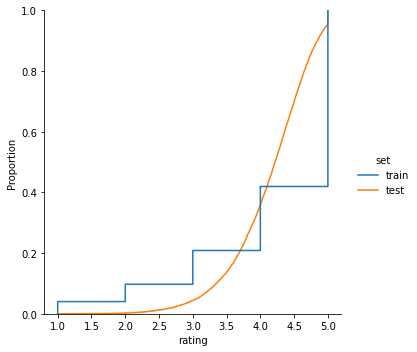

In [9]:
sns.displot(data=full.reset_index(),x='rating',kind='ecdf',hue='set')

In [12]:
with open(RESULTS_FILE_NAME,'w') as filee:
    filee.write("reviewerID-itemID,prediction\n")
    for i in range(len(outoutout)):
        filee.write(f"{outoutout.reviewerID.iloc[i]}-{outoutout.itemID.iloc[i]},{outoutout.rating.iloc[i]}\n")